In [1]:
import numpy as np
from math import log10
import cv2
import os

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision.transforms import ToTensor, Compose

In [2]:
def resize_and_crop(image_path, output_path, new_size=256):
    img = cv2.imread(image_path)    
    height, width = img.shape[:2]

    # Get smaller edge
    mini = min(height, width)
    scale = mini / new_size

    # Resize
    img_resized = cv2.resize(img, (int(width/scale), int(height/scale)))

    new_height, new_width = img_resized.shape[:2]

    x_start = (new_width - new_size) // 2
    y_start = (new_height - new_size) // 2

    img_cropped = img_resized[y_start:y_start+new_size, x_start:x_start+new_size]
    
    cv2.imwrite(output_path, img_cropped)

def process_folder(input_folder, output_folder, new_size=256):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)
        resize_and_crop(input_path, output_path, new_size=new_size)

In [3]:
input_folder = "./data/raw/train"
output_folder = "./data/intermediate/train"
process_folder(input_folder, output_folder)

input_folder = "./data/raw/valid"
output_folder = "./data/intermediate/valid"
process_folder(input_folder, output_folder)

In [4]:
input_folder = "./data/intermediate/train"
output_folder = "./data/scalling/train"
process_folder(input_folder, output_folder, 32)

input_folder = "./data/intermediate/valid"
output_folder = "./data/scalling/valid"
process_folder(input_folder, output_folder, 32)

# Jakieś miary

In [5]:
def SNE(img1: np.ndarray, img2: np.ndarray):
    img1_flatten, img2_flatten = img1.flatten(), img2.flatten()
    result = 0
    for pix1, pix2 in zip(img1_flatten, img2_flatten):
        result += pow(pix1-pix2, 2)
    return result

def PSNR(img1: np.ndarray, img2: np.ndarray, MAX=255):
    MSE = SNE(img1, img2) / img1.size
    return 10 * log10(pow(MAX, 2)/MSE)

def SSIM(img1: np.ndarray, img2: np.ndarray, L=255, k1=0.01, k2=0.03):
    mean1 = np.mean(img1)
    mean2 = np.mean(img2)
    var1 = np.var(img1)
    var2 = np.var(img2)
    cov = np.cov(img1, img2)
    c1 = (k1 * L) ** 2
    c2 = (k2 * L) ** 2
    return (2 * mean1 * mean2 + c1) * (2 * cov + c2) / ((pow(mean1, 2) * pow(mean2, 2) + c1) * (var1 * var2 + c2))

def LPIPS(img1: np.ndarray, img2: np.ndarray): ...
    # https://pypi.org/project/lpips/  

# Dataset

In [6]:
transform = Compose([
    ToTensor() # -> magicznie zmienia 32x32x3 -> 3x32x32, ale to dobrze bo tego oczekujemy
])

In [7]:
class ImageSet(Dataset):
    def __init__(self, images_folder, dest_folder='', transform=None):
        self.folder = images_folder  # folder do obrazów  do przekształcenia (inputy)
        self.dest = dest_folder  # folder z docelowymi obrazami (outputy)
        self.images, self.dest_images = self.read_images()
        self.transform = transform

    def read_images(self):
        images = []
        dest_images = []
        for filename in os.listdir(self.folder):
            image_name = os.path.join(self.folder, filename)
            img = cv2.imread(image_name)
            images.append(img)

            dest_img = cv2.imread(os.path.join(self.dest, filename))
            dest_images.append(dest_img)

        return images, dest_images

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        x_image = self.images[index]
        y_image = self.dest_images[index]
        if self.transform:
            x_image = self.transform(x_image)
            y_image = self.transform(y_image)
        return x_image, y_image

In [8]:
train_dataset = ImageSet("data/scalling/train", "data/intermediate/train", transform)
valid_dataset = ImageSet("data/scalling/valid", "data/intermediate/valid", transform)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)


# Model

In [9]:
class UpscaleCNN(nn.Module):
    def __init__(self):
        super(UpscaleCNN, self).__init__()

        # Encoder: 32x32 -> feature extraction
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # 32x32 -> 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
        )

        # Decoder: 4x4 -> 256x256 (upscaling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32 -> 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64 -> 128x128
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128x128 -> 256x256
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
model = UpscaleCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Pętla uczenia

In [11]:
import tqdm

num_epochs = 10

losses = {"train":[],"val":[]}

for epoch in range(num_epochs):
    model.train()
    for x, y in tqdm.tqdm(train_dataloader):
        optimizer.zero_grad() 
        out = model(x)
        
        loss = criterion(out, y)

        loss.backward()
        optimizer.step()
    
    model.eval()
    print(f"epoch #{epoch+1}, loss: {loss}")
    losses["train"].append(loss)
    with torch.no_grad():
        total_loss = 0.0
        for x, y in valid_dataset:
            out = model(x)

            loss = criterion(out, y)


            total_loss += loss.item()
        print("Validation loss:",total_loss)
    losses["val"].append(total_loss)

100%|██████████| 100/100 [00:03<00:00, 30.11it/s]


epoch #1, loss: 0.03601284325122833
Validation loss: 3.945333980023861


100%|██████████| 100/100 [00:03<00:00, 32.12it/s]


epoch #2, loss: 0.036181580275297165
Validation loss: 3.6417497862130404


100%|██████████| 100/100 [00:03<00:00, 31.00it/s]


epoch #3, loss: 0.034035976976156235
Validation loss: 3.4448329098522663


100%|██████████| 100/100 [00:03<00:00, 31.34it/s]


epoch #4, loss: 0.041576087474823
Validation loss: 3.287787920795381


100%|██████████| 100/100 [00:05<00:00, 18.58it/s]


epoch #5, loss: 0.03325312212109566
Validation loss: 3.2154688369482756


100%|██████████| 100/100 [00:03<00:00, 31.30it/s]


epoch #6, loss: 0.03135454282164574
Validation loss: 3.1028468664735556


100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


epoch #7, loss: 0.02817022241652012
Validation loss: 3.053606296889484


100%|██████████| 100/100 [00:03<00:00, 26.09it/s]


epoch #8, loss: 0.03844064101576805
Validation loss: 3.027410436887294


100%|██████████| 100/100 [00:03<00:00, 26.68it/s]


epoch #9, loss: 0.02300971746444702
Validation loss: 3.0060737296007574


100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


epoch #10, loss: 0.03634272888302803
Validation loss: 3.0282291197218


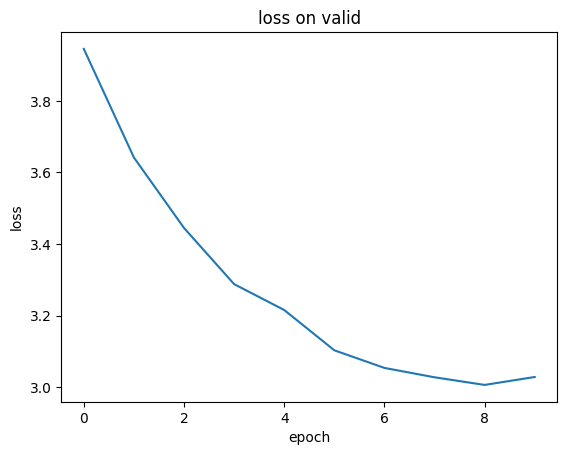

In [16]:
x = range(num_epochs)
y = losses['val']

plt.plot(x, y)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("loss on valid")
plt.show()